## 1. Import libraries

In [57]:
# basic utility libraries
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib widget

from matplotlib.image import imread
import tensorflow as tf
import cv2
from PIL import Image

#sky-kit learn (learning and optimisation helper libraries)
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score
from sklearn.model_selection import train_test_split

#keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input, BatchNormalization
from scikeras.wrappers import KerasClassifier
#from tensorflow.keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
#from keras.wrappers.scikit_learn import KerasClassifier (not in use)
from keras.optimizers import Adam
from keras.layers import Dropout
from keras.utils import to_categorical
from keras.metrics import Precision, Recall


## 2. Importing training dataset 

In [12]:
train=pd.read_csv('German Traffic Sign/Train.csv')
X_train=train['Path']
y_train=train.ClassId
train

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,27,26,5,5,22,20,20,Train/20/00020_00000_00000.png
1,28,27,5,6,23,22,20,Train/20/00020_00000_00001.png
2,29,26,6,5,24,21,20,Train/20/00020_00000_00002.png
3,28,27,5,6,23,22,20,Train/20/00020_00000_00003.png
4,28,26,5,5,23,21,20,Train/20/00020_00000_00004.png
...,...,...,...,...,...,...,...,...
39204,52,56,5,6,47,51,42,Train/42/00042_00007_00025.png
39205,56,58,5,5,51,53,42,Train/42/00042_00007_00026.png
39206,58,62,5,6,53,57,42,Train/42/00042_00007_00027.png
39207,63,69,5,7,58,63,42,Train/42/00042_00007_00028.png


In [13]:
data_dir = "German Traffic Sign"
train_imgpath= list((data_dir + '/' + str(train.Path[i])) for i in range(len(train.Path)))

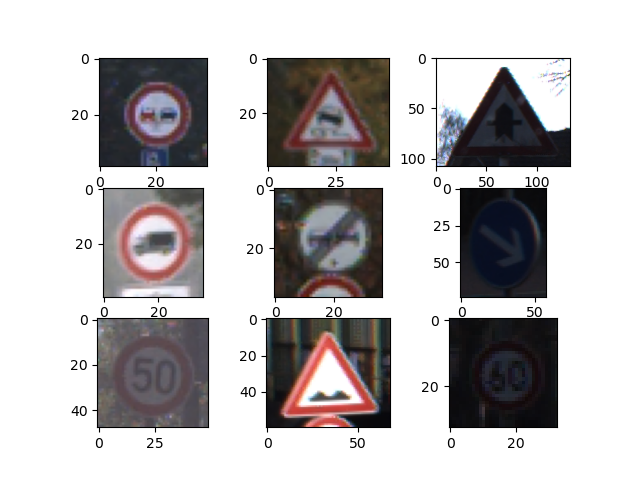

In [14]:

for i in range(0,9):
    plt.subplot(3,3,1+i)
    seed=np.random.randint(0,39210)
    im = Image.open(train_imgpath[seed])  
    plt.imshow(im)
   
plt.show()



## 3. Pre-processing image data converting images into arrays of the form (28,28,3) for faster processing

In [15]:
train_data=[]
train_labels=[]


path = "German Traffic Sign"
for i in range(len(train.Path)):
    image=cv2.imread(train_imgpath[i])
    image_from_array = Image.fromarray(image, 'RGB')
    size_image = image_from_array.resize((30,30))
    train_data.append(np.array(size_image))
    train_labels.append(train.ClassId[i])


X=np.array(train_data)
y=np.array(train_labels)

3.1 Spliting the images into train and validation sets

In [17]:
#hold out validation
X_train, X_val, y_train, y_val = train_test_split( X, y, test_size=0.20, random_state=7777)  

print(X_train)

[[[[ 47  41  43]
   [ 46  41  44]
   [ 41  46  54]
   ...
   [116 106  90]
   [ 64  68  83]
   [ 82  78 106]]

  [[ 50  43  44]
   [ 48  42  42]
   [ 40  41  47]
   ...
   [132 104  89]
   [ 56  51  51]
   [ 40  37  41]]

  [[ 52  43  43]
   [ 46  40  40]
   [ 37  35  40]
   ...
   [122  97  91]
   [104  75  70]
   [ 46  35  37]]

  ...

  [[ 60  67  68]
   [ 48  49  48]
   [ 37  32  31]
   ...
   [ 41  34  37]
   [ 42  36  37]
   [ 68  56  53]]

  [[ 64  77  82]
   [ 57  61  56]
   [ 47  39  40]
   ...
   [ 38  33  33]
   [ 42  37  36]
   [ 83  65  61]]

  [[ 61  65  69]
   [ 74  76  69]
   [ 53  52  55]
   ...
   [ 54  39  39]
   [ 48  40  39]
   [ 80  67  64]]]


 [[[ 73  68  71]
   [ 65  64  72]
   [ 58  58  69]
   ...
   [ 90  83  84]
   [ 81  73  79]
   [ 87  78  84]]

  [[ 58  59  62]
   [ 53  56  61]
   [ 51  53  60]
   ...
   [ 84  71  72]
   [ 78  65  70]
   [ 73  63  67]]

  [[ 53  54  58]
   [ 45  49  53]
   [ 44  48  52]
   ...
   [ 65  62  65]
   [ 62  57  60]
   [ 60  54

3.2 Pixel Normalization (Scaling the image pixels)

In [18]:
X_train = X_train.astype('float32')/255 
X_val = X_val.astype('float32')/255

3.3 One-hot encoding the train and validation set

In [19]:
y_train = to_categorical(y_train, 43)
y_val = to_categorical(y_val, 43)

print(y_train)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]]


3.4 Grid Search to determine the layers and neurons in each layer in the sequential model.

In [12]:
def create_model(layers):
    cnn = tf.keras.models.Sequential()
    cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding="same", activation="relu", input_shape=[28, 28, 3]))
    cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2, padding='valid'))
    cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding="same", activation="relu"))
    cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2, padding='valid'))
    cnn.add(tf.keras.layers.Flatten())
    
    for i, nodes in enumerate(layers):
        cnn.add(tf.keras.layers.Dense(units=nodes, activation='relu'))
            
    cnn.add(tf.keras.layers.Dense(units=43, activation='softmax'))
    
    cnn.compile(optimizer = 'Adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
    return cnn

layers = [[128],(256, 128),(200, 150, 120),(512,256)]
model = KerasClassifier(model=create_model, verbose=1, layers = layers)

param_grid = dict(layers=layers)
grid = GridSearchCV(estimator=model, param_grid=param_grid, verbose=1)
grid_results = grid.fit(X_train,y_train, validation_data=(X_val, y_val))
print("Best: {0}, using {1}".format(grid_results.best_score_, grid_results.best_params_))
means = grid_results.cv_results_['mean_test_score']
stds = grid_results.cv_results_['std_test_score']
params = grid_results.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print('{0} ({1}) with: {2}'.format(mean, stdev, param))

Fitting 5 folds for each of 4 candidates, totalling 20 fits
981/981 [==============================] - 25s 24ms/step - loss: 0.0665 - accuracy: 0.4682 - val_loss: 0.0266 - val_accuracy: 0.7955
Best: 0.7715104697785151, using {'layers': (512, 256)}
0.6643581356025827 (0.05957948460192908) with: {'layers': [128]}
0.6482281563425809 (0.06108500154043954) with: {'layers': (256, 128)}
0.5360077020485556 (0.026475892940110084) with: {'layers': (200, 150, 120)}
0.7715104697785151 (0.03487675646377544) with: {'layers': (512, 256)}


In [21]:
def create_model(layers):
    cnn = tf.keras.models.Sequential()
    cnn.add(tf.keras.layers.Conv2D(filters=16, kernel_size=3, padding="same", activation="relu", input_shape=[30, 30, 3]))
    cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding="same", activation="relu"))
    cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2, padding='valid'))
    cnn.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding="same", activation="relu"))
    cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2, padding='valid'))
    
    cnn.add(tf.keras.layers.Flatten())
    
    for i, nodes in enumerate(layers):
        cnn.add(tf.keras.layers.Dense(units=nodes, activation='relu'))
            
    cnn.add(tf.keras.layers.Dense(units=43, activation='softmax'))
    
    cnn.compile(optimizer = 'Adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
    return cnn

layers = [[128],(256, 128),(512,256)]
model = KerasClassifier(model=create_model, verbose=1, layers = layers)

param_grid = dict(layers=layers)
grid = GridSearchCV(estimator=model, param_grid=param_grid, verbose=1)
grid_results = grid.fit(X_train,y_train, validation_data=(X_val, y_val))
print("Best: {0}, using {1}".format(grid_results.best_score_, grid_results.best_params_))
means = grid_results.cv_results_['mean_test_score']
stds = grid_results.cv_results_['std_test_score']
params = grid_results.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print('{0} ({1}) with: {2}'.format(mean, stdev, param))

Fitting 5 folds for each of 3 candidates, totalling 15 fits
981/981 [==============================] - 51s 51ms/step - loss: 0.0486 - accuracy: 0.6225 - val_loss: 0.0091 - val_accuracy: 0.9473
Best: 0.9279820042289005, using {'layers': (512, 256)}
0.8712344310902089 (0.01004643027084358) with: {'layers': [128]}
0.8596949365957123 (0.03248144395807306) with: {'layers': (256, 128)}
0.9279820042289005 (0.01426812270387977) with: {'layers': (512, 256)}


In [26]:
def create_model(layers):
    cnn = tf.keras.models.Sequential()
    cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding="same", activation="relu", input_shape=[30, 30, 3]))
    cnn.add(tf.keras.layers.Conv2D(filters=128, kernel_size=3, padding="same", activation="relu"))
    cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2, padding='valid'))
    cnn.add(tf.keras.layers.Conv2D(filters=512, kernel_size=3, padding="same", activation="relu"))
    cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2, padding='valid'))
    
    cnn.add(tf.keras.layers.Flatten())
    
    for i, nodes in enumerate(layers):
        cnn.add(tf.keras.layers.Dense(units=nodes, activation='relu'))
            
    cnn.add(tf.keras.layers.Dense(units=43, activation='softmax'))
    
    cnn.compile(optimizer = 'Adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
    return cnn

layers = [[128],(256, 128),(512,256)]
model = KerasClassifier(model=create_model, verbose=1, layers = layers)

param_grid = dict(layers=layers)
grid = GridSearchCV(estimator=model, param_grid=param_grid, verbose=1)
grid_results = grid.fit(X_train,y_train, validation_data=(X_val, y_val))
print("Best: {0}, using {1}".format(grid_results.best_score_, grid_results.best_params_))
means = grid_results.cv_results_['mean_test_score']
stds = grid_results.cv_results_['std_test_score']
params = grid_results.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print('{0} ({1}) with: {2}'.format(mean, stdev, param))

Fitting 5 folds for each of 3 candidates, totalling 15 fits
981/981 [==============================] - 177s 180ms/step - loss: 0.0397 - accuracy: 0.6917 - val_loss: 0.0045 - val_accuracy: 0.9802
Best: 0.9729970844683976, using {'layers': (512, 256)}
0.9637844914330183 (0.016074464481357718) with: {'layers': [128]}
0.9542194917158158 (0.005232596861479916) with: {'layers': (256, 128)}
0.9729970844683976 (0.004869463575756249) with: {'layers': (512, 256)}


3.5 Grid Search to determine the batch size

In [20]:
def create_model1():
    cnn = tf.keras.models.Sequential()
    cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding="same", activation="relu", input_shape=[30, 30, 3]))
    cnn.add(tf.keras.layers.Conv2D(filters=128, kernel_size=3, padding="same", activation="relu"))
    cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2, padding='valid'))
    cnn.add(tf.keras.layers.Conv2D(filters=512, kernel_size=3, padding="same", activation="relu"))
    cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2, padding='valid'))

    cnn.add(tf.keras.layers.Flatten())

    cnn.add(tf.keras.layers.Dense(units=512, activation='relu'))
    cnn.add(tf.keras.layers.Dense(units=256, activation='relu'))

    cnn.add(tf.keras.layers.Dense(units=43, activation='softmax'))
    
    cnn.compile(optimizer = 'Adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
    return cnn

model = KerasClassifier(model = create_model1, verbose = 1)

batch_size = [20,40]
param_grid = dict(batch_size=batch_size)

grid = GridSearchCV(estimator = model, param_grid = param_grid, verbose = 1)
grid_results = grid.fit(X_train,y_train, validation_data=(X_val, y_val))

print("Best: {0}, using {1}".format(grid_results.best_score_, grid_results.best_params_))
means = grid_results.cv_results_['mean_test_score']
params = grid_results.cv_results_['params']
for mean,param in zip(means,params):
    print('{0} with: {1}'.format(mean,param))

Fitting 5 folds for each of 2 candidates, totalling 10 fits
1569/1569 [==============================] - 142s 90ms/step - loss: 0.0317 - accuracy: 0.7496 - val_loss: 0.0052 - val_accuracy: 0.9699
Best: 0.985175380865549, using {'batch_size': 20}
0.985175380865549 with: {'batch_size': 20}
0.9574712396601737 with: {'batch_size': 40}


3.6 Grid Search to determine the dropout rate

In [23]:
def create_model2(dropout):
    cnn = tf.keras.models.Sequential()

    cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding="same", activation="relu", input_shape=[30, 30, 3]))
    cnn.add(tf.keras.layers.Conv2D(filters=128, kernel_size=3, padding="same", activation="relu"))
    cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2, padding='valid'))
    cnn.add(tf.keras.layers.Conv2D(filters=512, kernel_size=3, padding="same", activation="relu"))
    cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2, padding='valid'))

    cnn.add(tf.keras.layers.Flatten())
    
    cnn.add(tf.keras.layers.Dense(units=256, activation='relu'))
    cnn.add(Dropout(dropout))
    cnn.add(tf.keras.layers.Dense(units=128, activation='relu'))
    cnn.add(Dropout(dropout))
    cnn.add(tf.keras.layers.Dense(units=43, activation='softmax'))
    
    cnn.compile(optimizer = 'Adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
    return cnn

dropout = [0.0, 0.1, 0.2]
model = KerasClassifier(model = create_model2, verbose = 1, batch_size=20, dropout=dropout)

dropout = [0.0, 0.1, 0.2]
param_grid = dict(dropout=dropout)

grid = GridSearchCV(estimator = model, param_grid = param_grid, verbose = 1)
grid_results = grid.fit(X_train,y_train, validation_data=(X_val, y_val))

print("Best: {0}, using {1}".format(grid_results.best_score_, grid_results.best_params_))
means = grid_results.cv_results_['mean_test_score']
params = grid_results.cv_results_['params']
for mean,param in zip(means,params):
    print('{0} with: {1}'.format(mean,param))

Fitting 5 folds for each of 3 candidates, totalling 15 fits
1569/1569 [==============================] - 114s 72ms/step - loss: 0.0360 - accuracy: 0.7226 - val_loss: 0.0038 - val_accuracy: 0.9784
Best: 0.9798196967324733, using {'dropout': 0.1}
0.9773966035146859 with: {'dropout': 0.0}
0.9798196967324733 with: {'dropout': 0.1}
0.9683429969741952 with: {'dropout': 0.2}


### 4. CNN Model

In [26]:
cnn = tf.keras.models.Sequential()

cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding="same", activation="relu", input_shape=[30, 30, 3]))
cnn.add(tf.keras.layers.Conv2D(filters=128, kernel_size=3, padding="same", activation="relu"))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2, padding='valid'))
cnn.add(tf.keras.layers.Conv2D(filters=512, kernel_size=3, padding="same", activation="relu"))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2, padding='valid'))

cnn.add(tf.keras.layers.Flatten())

cnn.add(tf.keras.layers.Dense(units=256, activation='relu'))
cnn.add(Dropout(0.1))
cnn.add(tf.keras.layers.Dense(units=128, activation='relu'))
cnn.add(Dropout(0.1))

cnn.add(tf.keras.layers.Dense(units=43, activation='softmax'))

# compile the model
cnn.compile(optimizer = 'Adam', loss = 'binary_crossentropy', metrics = ['accuracy',Precision(), Recall()])

history = cnn.fit(X_train, y_train, batch_size=20, epochs=20,validation_data=(X_val, y_val))

Epoch 1/20
1569/1569 [==============================] - 140s 89ms/step - loss: 0.0401 - accuracy: 0.6874 - val_loss: 0.0037 - val_accuracy: 0.9778
Epoch 2/20
1569/1569 [==============================] - 186s 118ms/step - loss: 0.0027 - accuracy: 0.9868 - val_loss: 0.0013 - val_accuracy: 0.9944
Epoch 3/20
1569/1569 [==============================] - 185s 118ms/step - loss: 0.0013 - accuracy: 0.9940 - val_loss: 9.7843e-04 - val_accuracy: 0.9948
Epoch 4/20
1569/1569 [==============================] - 185s 118ms/step - loss: 8.9077e-04 - accuracy: 0.9965 - val_loss: 0.0032 - val_accuracy: 0.9829
Epoch 5/20
1569/1569 [==============================] - 185s 118ms/step - loss: 7.9687e-04 - accuracy: 0.9968 - val_loss: 9.3348e-04 - val_accuracy: 0.9957
Epoch 6/20
1569/1569 [==============================] - 185s 118ms/step - loss: 0.0011 - accuracy: 0.9950 - val_loss: 5.8802e-04 - val_accuracy: 0.9962
Epoch 7/20
1569/1569 [==============================] - 195s 124ms/step - loss: 6.7064e-04 - 

In [48]:
cnn = tf.keras.models.Sequential()

cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding="same", activation="relu", input_shape=[30, 30, 3]))
cnn.add(tf.keras.layers.Conv2D(filters=128, kernel_size=3, padding="same", activation="relu"))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2, padding='valid'))
cnn.add(tf.keras.layers.Conv2D(filters=512, kernel_size=3, padding="same", activation="relu"))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2, padding='valid'))

cnn.add(tf.keras.layers.Flatten())

cnn.add(tf.keras.layers.Dense(units=256, activation='relu'))
cnn.add(Dropout(0.1))
cnn.add(tf.keras.layers.Dense(units=128, activation='relu'))
cnn.add(Dropout(0.1))

cnn.add(tf.keras.layers.Dense(units=43, activation='softmax'))

# compile the model
cnn.compile(optimizer = 'Adam', loss = 'binary_crossentropy', metrics = ['accuracy',Precision(), Recall()])

history = cnn.fit(X_train, y_train, batch_size=20, epochs=20,validation_data=(X_val, y_val))

Epoch 1/20
1569/1569 [==============================] - 151s 95ms/step - loss: 0.0390 - accuracy: 0.7141 - precision: 0.9206 - recall: 0.6580 - val_loss: 0.0026 - val_accuracy: 0.9880 - val_precision: 0.9920 - val_recall: 0.9852
Epoch 2/20
1569/1569 [==============================] - 150s 95ms/step - loss: 0.0027 - accuracy: 0.9869 - precision: 0.9896 - recall: 0.9855 - val_loss: 0.0013 - val_accuracy: 0.9945 - val_precision: 0.9969 - val_recall: 0.9938
Epoch 3/20
1569/1569 [==============================] - 151s 96ms/step - loss: 0.0014 - accuracy: 0.9938 - precision: 0.9946 - recall: 0.9933 - val_loss: 9.3448e-04 - val_accuracy: 0.9955 - val_precision: 0.9967 - val_recall: 0.9948
Epoch 4/20
1569/1569 [==============================] - 159s 101ms/step - loss: 8.2903e-04 - accuracy: 0.9965 - precision: 0.9970 - recall: 0.9962 - val_loss: 0.0010 - val_accuracy: 0.9950 - val_precision: 0.9955 - val_recall: 0.9949
Epoch 5/20
1569/1569 [==============================] - 156s 99ms/step - lo

In [80]:
print(np.mean(history.history['accuracy']))
print(np.mean(history.history['precision']))


0.982889661192894
0.9935130506753922


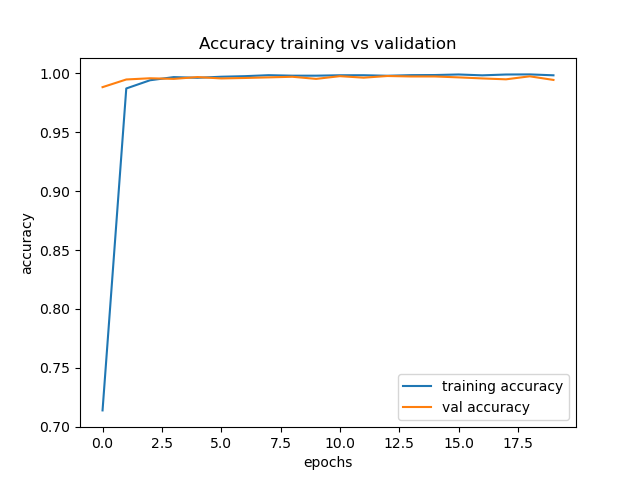

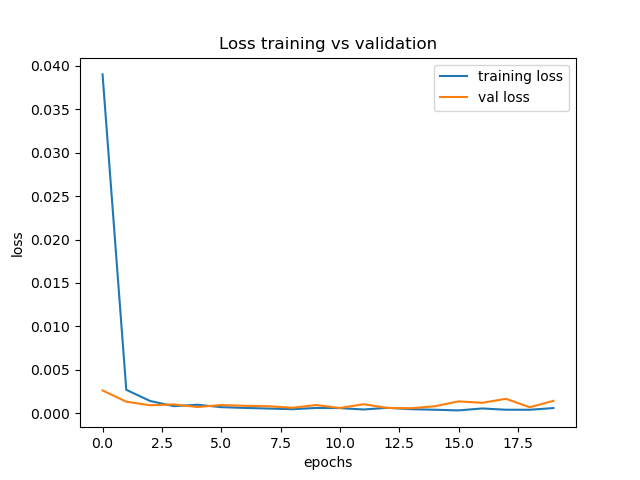

In [69]:
plt.figure(0)
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy training vs validation')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

plt.figure(1)
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss training vs validation')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

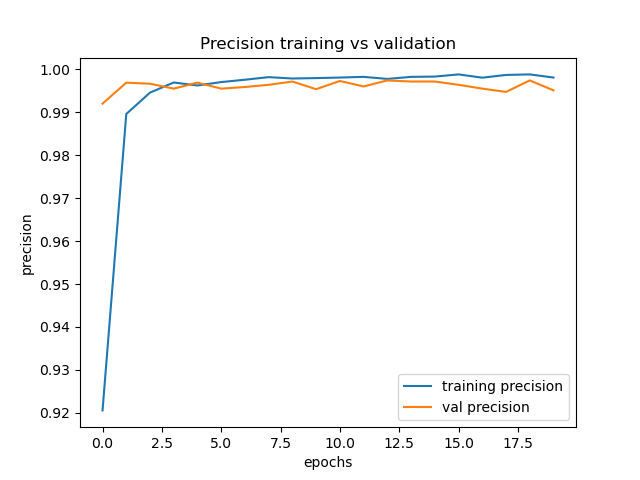

In [70]:
plt.figure(2)
plt.plot(history.history['precision'], label='training precision')
plt.plot(history.history['val_precision'], label='val precision')
plt.title('Precision training vs validation')
plt.xlabel('epochs')
plt.ylabel('precision')
plt.legend()

preparing test data

In [53]:
test=pd.read_csv('German Traffic Sign/Test.csv')
X_test=train['Path']
y_test=train.ClassId

In [54]:
data_dir = "German Traffic Sign"
test_imgpath= list((data_dir + '/' + str(test.Path[i])) for i in range(len(test.Path)))

In [55]:
test_data=[]
test_labels=[]


path = "German Traffic Sign"
for i in range(len(test.Path)):
    image=cv2.imread(test_imgpath[i])
    image_from_array = Image.fromarray(image, 'RGB')
    size_image = image_from_array.resize((30,30))
    test_data.append(np.array(size_image))
    test_labels.append(test.ClassId[i])


X_test=np.array(test_data)
y_test=np.array(test_labels)

X_test = X_test.astype('float32')/255 

In [76]:
#predictions-
pred = cnn.predict(X_test)

395/395 [==============================] - 35s 89ms/step
[[0.0000000e+00 3.2533433e-31 1.4101048e-34 ... 1.9557824e-25
  5.4058785e-33 2.6306288e-25]
 [0.0000000e+00 1.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 ...
 [1.1377457e-06 3.9068054e-06 3.1829025e-08 ... 3.6603968e-08
  3.2450268e-06 1.8771228e-08]
 [1.9606410e-37 2.0925752e-23 4.4347059e-20 ... 1.1610140e-19
  5.8733810e-32 7.4095365e-18]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]]


In [75]:
vd_preds = np.argmax(pred,axis=1)
print(vd_preds)
accuracy_score(y_test, vd_preds)


[16  1 38 ... 32  7 10]


0.965083135391924

In [78]:
precision_score(y_test, vd_preds,average='micro')

0.965083135391924

In [45]:
from sklearn.metrics import classification_report
print(classification_report(y_test, vd_preds))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99        60
           1       0.99      0.99      0.99       720
           2       0.98      1.00      0.99       750
           3       0.97      0.96      0.96       450
           4       1.00      0.98      0.99       660
           5       0.96      0.97      0.97       630
           6       1.00      0.92      0.96       150
           7       1.00      0.99      0.99       450
           8       0.99      0.96      0.97       450
           9       0.99      1.00      0.99       480
          10       1.00      0.99      1.00       660
          11       0.94      0.99      0.96       420
          12       1.00      1.00      1.00       690
          13       1.00      1.00      1.00       720
          14       1.00      1.00      1.00       270
          15       1.00      1.00      1.00       210
          16       0.98      0.99      0.99       150
          17       1.00    